<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/seblock_50epoch_flower_D_se_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import argparse

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
import torchvision.transforms as transforms

In [7]:
import torchvision.datasets as dset

In [8]:
import torchvision.utils as vutils

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [10]:
import glob

In [11]:
from torch.utils.data import Dataset
from PIL import Image

In [12]:
from torch.utils.data import DataLoader
import torchvision

In [13]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 13.7 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 490MB/s]


In [14]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [15]:
#ハイパーパラメータの設定

In [16]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [17]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [18]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [19]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [20]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [22]:
#モデルの設定

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [25]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [26]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [27]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [28]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [29]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [30]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [31]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [32]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [33]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [34]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [35]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [36]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [37]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [38]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [39]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf, se = True )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, se = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, se = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [40]:
#モデルのトレーニング

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [42]:
device

device(type='cuda')

In [43]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [44]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:08<00:00, 11.62it/s]


epoch: 0, lossD:0.17062767419638564, lossG:9.025557272642562,lossG_fake:4.770232594128951, lossG_real:4.25532465189406 ,equality:0.514907942234891


evaluate:111.65177917480469,kid_mean:0.06857859343290329, kid_std:0.03629160672426224,kid_:(tensor(0.0686), tensor(0.0363))


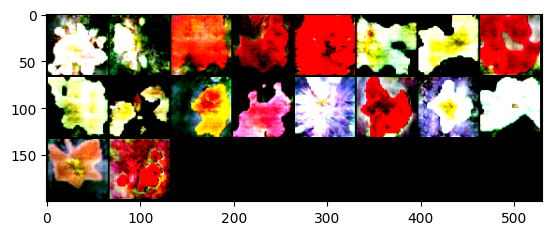

100%|██████████| 103/103 [00:09<00:00, 11.40it/s]


epoch: 1, lossD:0.15435218386062718, lossG:9.226956404528572,lossG_fake:4.860824080346857, lossG_real:4.36613230103428 ,equality:0.4946917793125776


evaluate:110.49842834472656,kid_mean:0.07781419157981873, kid_std:0.0404459610581398,kid_:(tensor(0.0778), tensor(0.0404))


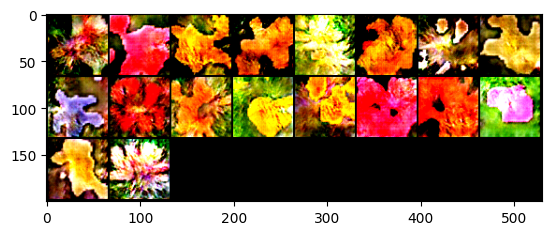

100%|██████████| 103/103 [00:09<00:00, 11.15it/s]


epoch: 2, lossD:0.22365777170990855, lossG:9.392628054017003,lossG_fake:4.98468137423969, lossG_real:4.407946689614972 ,equality:0.5767346846247179


evaluate:111.5501480102539,kid_mean:0.0807371437549591, kid_std:0.04094691947102547,kid_:(tensor(0.0807), tensor(0.0409))


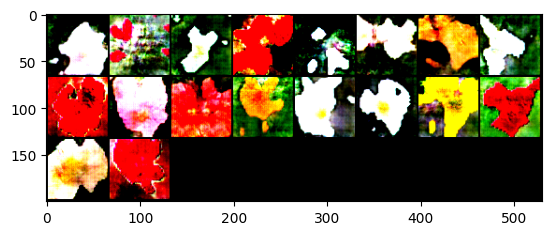

100%|██████████| 103/103 [00:09<00:00, 11.32it/s]


epoch: 3, lossD:0.171642109570862, lossG:9.377201274760719,lossG_fake:5.06280623824851, lossG_real:4.3143950110500295 ,equality:0.7484112271984804


evaluate:111.8729019165039,kid_mean:0.07628582417964935, kid_std:0.03295133635401726,kid_:(tensor(0.0763), tensor(0.0330))


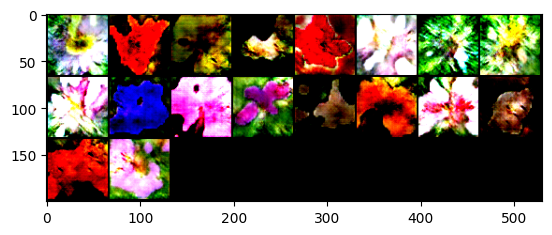

100%|██████████| 103/103 [00:08<00:00, 11.70it/s]


epoch: 4, lossD:0.12481035093225322, lossG:9.03858123705225,lossG_fake:4.708965192720728, lossG_real:4.32961610914434 ,equality:0.37934908357638797


evaluate:111.51795196533203,kid_mean:0.07750847190618515, kid_std:0.03941715508699417,kid_:(tensor(0.0775), tensor(0.0394))


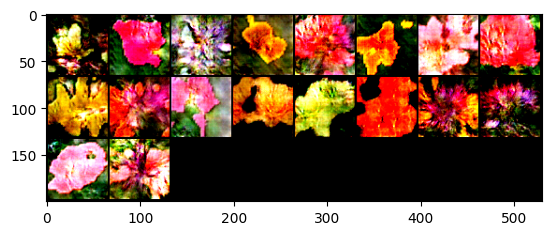

100%|██████████| 103/103 [00:08<00:00, 11.69it/s]


epoch: 5, lossD:0.12521820278494683, lossG:9.233042300326153,lossG_fake:4.934670665889111, lossG_real:4.29837164601076 ,equality:0.6362990198783507


evaluate:110.77064514160156,kid_mean:0.07837841659784317, kid_std:0.04139130935072899,kid_:(tensor(0.0784), tensor(0.0414))


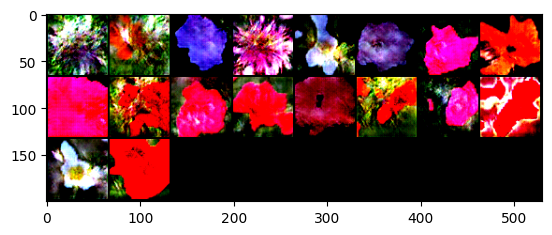

100%|██████████| 103/103 [00:08<00:00, 11.67it/s]


epoch: 6, lossD:0.11095930957823123, lossG:9.357176683481457,lossG_fake:5.004021049703209, lossG_real:4.353155607158698 ,equality:0.6508654425445117


evaluate:111.1031723022461,kid_mean:0.07967577129602432, kid_std:0.04162997007369995,kid_:(tensor(0.0797), tensor(0.0416))


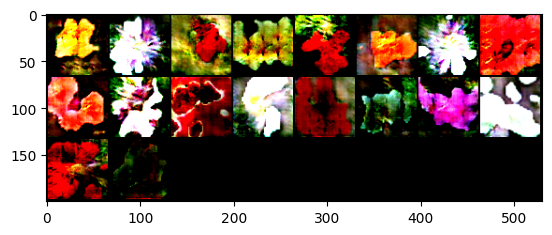

100%|██████████| 103/103 [00:08<00:00, 11.48it/s]


epoch: 7, lossD:0.14851623543908873, lossG:9.501767714046737,lossG_fake:5.085163433574936, lossG_real:4.416604268898085 ,equality:0.668559164676851


evaluate:112.37298583984375,kid_mean:0.0680561512708664, kid_std:0.037550680339336395,kid_:(tensor(0.0681), tensor(0.0376))


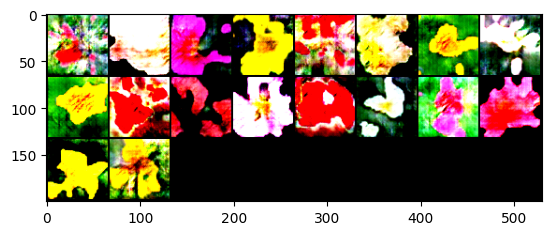

100%|██████████| 103/103 [00:08<00:00, 11.49it/s]


epoch: 8, lossD:0.1092226118645043, lossG:9.825538635253906,lossG_fake:5.306113775494029, lossG_real:4.519424919943208 ,equality:0.7866888555508211


evaluate:112.40763092041016,kid_mean:0.08170878142118454, kid_std:0.04529521241784096,kid_:(tensor(0.0817), tensor(0.0453))


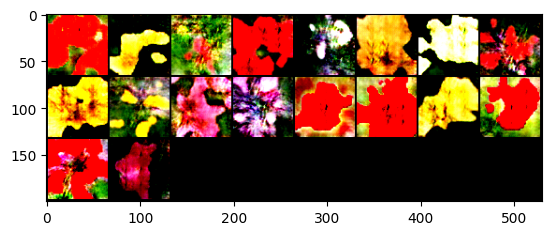

100%|██████████| 103/103 [00:08<00:00, 11.47it/s]


epoch: 9, lossD:0.17775342624308993, lossG:9.661042667129665,lossG_fake:5.156307152174051, lossG_real:4.50473556587997 ,equality:0.6515715862940814


evaluate:111.75485229492188,kid_mean:0.08252391964197159, kid_std:0.043691184371709824,kid_:(tensor(0.0825), tensor(0.0437))


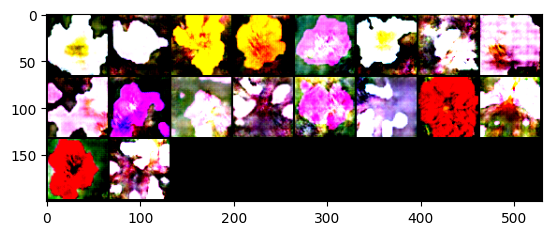

100%|██████████| 103/103 [00:08<00:00, 11.67it/s]


epoch: 10, lossD:0.14011858608031158, lossG:9.352523687973763,lossG_fake:5.014869993172803, lossG_real:4.337653667024038 ,equality:0.6772163261487645


evaluate:113.02619171142578,kid_mean:0.08132295310497284, kid_std:0.05548280104994774,kid_:(tensor(0.0813), tensor(0.0555))


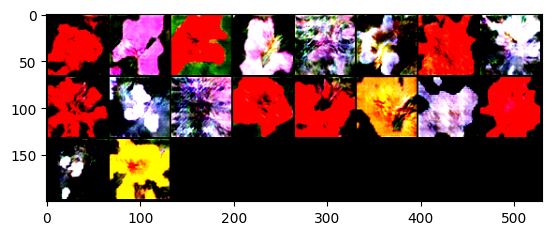

100%|██████████| 103/103 [00:08<00:00, 11.85it/s]


epoch: 11, lossD:0.10902532092431216, lossG:9.580826490828134,lossG_fake:5.194673262753533, lossG_real:4.386153235018832 ,equality:0.8085200277347004


evaluate:113.24243927001953,kid_mean:0.0801888108253479, kid_std:0.040338460355997086,kid_:(tensor(0.0802), tensor(0.0403))


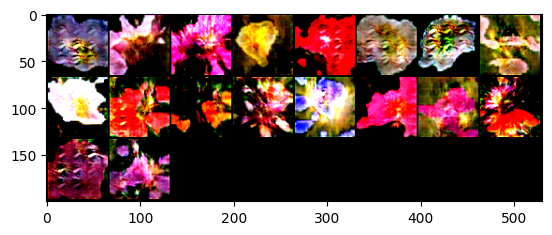

100%|██████████| 103/103 [00:08<00:00, 11.66it/s]


epoch: 12, lossD:0.21079930252603535, lossG:9.737030881122479,lossG_fake:5.157150537064932, lossG_real:4.5798804042408765 ,equality:0.5772701328240553


evaluate:112.82374572753906,kid_mean:0.07691049575805664, kid_std:0.041494764387607574,kid_:(tensor(0.0769), tensor(0.0415))


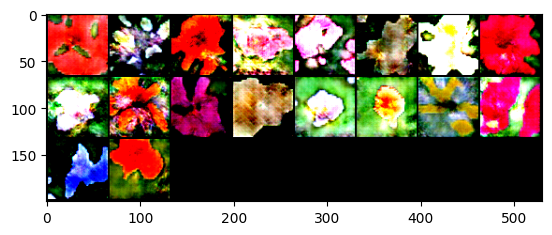

100%|██████████| 103/103 [00:09<00:00, 11.15it/s]


epoch: 13, lossD:0.1280087282772637, lossG:9.652824804620835,lossG_fake:5.0987054144294515, lossG_real:4.554119376302923 ,equality:0.5445860381265284


evaluate:112.57859802246094,kid_mean:0.0790206789970398, kid_std:0.038683485239744186,kid_:(tensor(0.0790), tensor(0.0387))


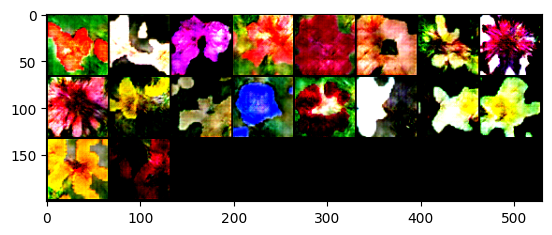

100%|██████████| 103/103 [00:09<00:00, 11.08it/s]


epoch: 14, lossD:0.1771008048966093, lossG:9.625359086157049,lossG_fake:5.194980414168349, lossG_real:4.430378669673956 ,equality:0.7646017444943922


evaluate:112.85780334472656,kid_mean:0.08913683146238327, kid_std:0.04588470607995987,kid_:(tensor(0.0891), tensor(0.0459))


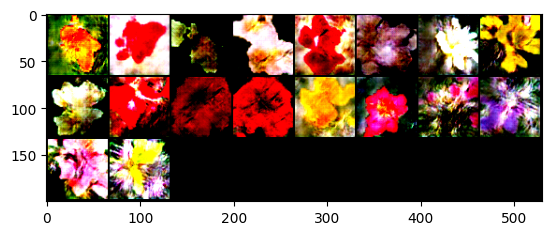

100%|██████████| 103/103 [00:08<00:00, 11.66it/s]


epoch: 15, lossD:0.13135719413245187, lossG:9.602897157946837,lossG_fake:5.250050077160585, lossG_real:4.352847051851958 ,equality:0.8972030253086274


evaluate:112.42396545410156,kid_mean:0.07654175162315369, kid_std:0.0460389144718647,kid_:(tensor(0.0765), tensor(0.0460))


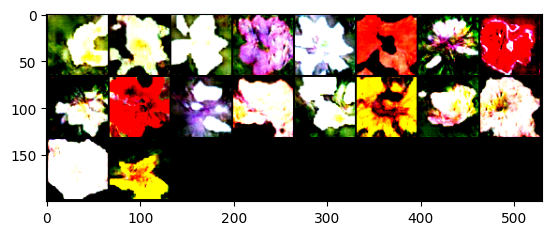

100%|██████████| 103/103 [00:08<00:00, 11.67it/s]


epoch: 16, lossD:0.17579290429943972, lossG:9.537431777102276,lossG_fake:5.136987366722625, lossG_real:4.400444434684458 ,equality:0.7365429320381676


evaluate:112.01318359375,kid_mean:0.07543540000915527, kid_std:0.036005113273859024,kid_:(tensor(0.0754), tensor(0.0360))


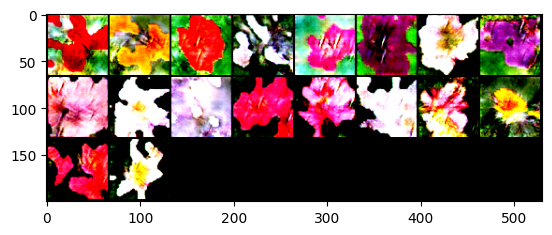

100%|██████████| 103/103 [00:08<00:00, 11.53it/s]


epoch: 17, lossD:0.1414603037416067, lossG:9.417544091789468,lossG_fake:4.94175426936844, lossG_real:4.475789858299551 ,equality:0.46596441106888875


evaluate:111.39118194580078,kid_mean:0.07033149898052216, kid_std:0.043641746044158936,kid_:(tensor(0.0703), tensor(0.0436))


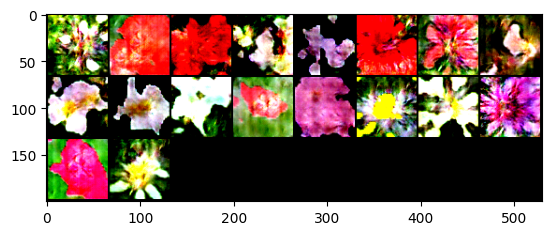

100%|██████████| 103/103 [00:09<00:00, 11.21it/s]


epoch: 18, lossD:0.15995964558017486, lossG:9.440913987391204,lossG_fake:4.958022011136546, lossG_real:4.482891929381102 ,equality:0.47513008175544336


evaluate:111.65214538574219,kid_mean:0.07543932646512985, kid_std:0.03373898193240166,kid_:(tensor(0.0754), tensor(0.0337))


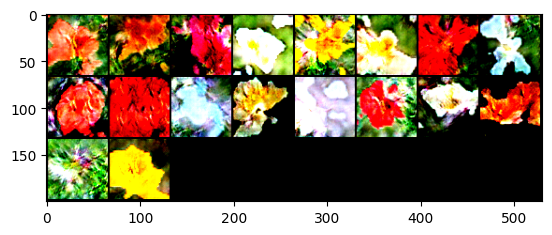

100%|██████████| 103/103 [00:09<00:00, 11.19it/s]


epoch: 19, lossD:0.08794105383883981, lossG:9.156508816098704,lossG_fake:4.765524780866012, lossG_real:4.390984037547436 ,equality:0.3745407433185761


evaluate:111.59821319580078,kid_mean:0.08243239670991898, kid_std:0.042708300054073334,kid_:(tensor(0.0824), tensor(0.0427))


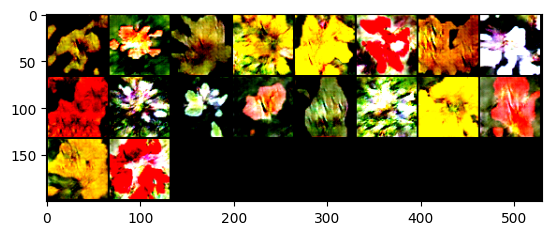

100%|██████████| 103/103 [00:09<00:00, 11.28it/s]


epoch: 20, lossD:0.20824652217617892, lossG:9.71716888205519,lossG_fake:5.199040841130377, lossG_real:4.518128046711672 ,equality:0.6809127944187052


evaluate:109.96759033203125,kid_mean:0.07533462345600128, kid_std:0.037454910576343536,kid_:(tensor(0.0753), tensor(0.0375))


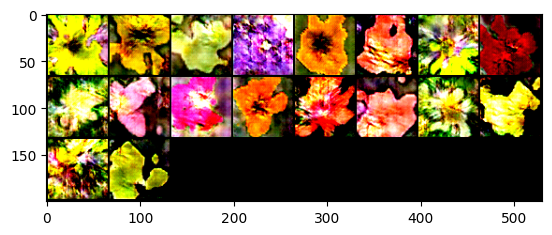

100%|██████████| 103/103 [00:09<00:00, 11.41it/s]


epoch: 21, lossD:0.22170813347312432, lossG:9.741839163511703,lossG_fake:5.226222021487152, lossG_real:4.515617143471264 ,equality:0.7106048780158885


evaluate:110.70916748046875,kid_mean:0.07949591428041458, kid_std:0.04781627282500267,kid_:(tensor(0.0795), tensor(0.0478))


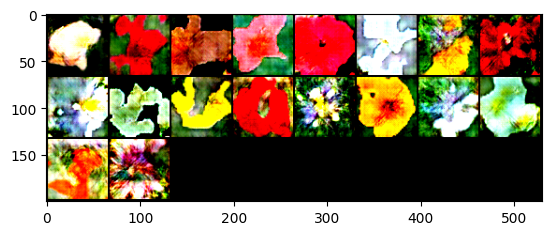

100%|██████████| 103/103 [00:09<00:00, 11.17it/s]


epoch: 22, lossD:0.16380703141822398, lossG:9.519578220774827,lossG_fake:5.097233834775906, lossG_real:4.422344394100523 ,equality:0.6748894406753836


evaluate:110.25286102294922,kid_mean:0.08337293565273285, kid_std:0.047636065632104874,kid_:(tensor(0.0834), tensor(0.0476))


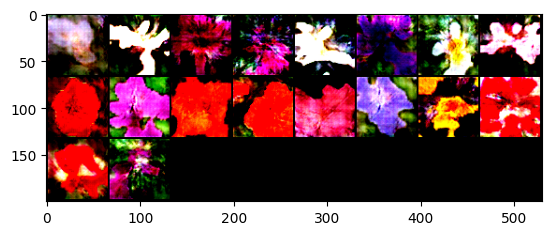

100%|██████████| 103/103 [00:08<00:00, 11.70it/s]


epoch: 23, lossD:0.12265037739812171, lossG:9.437793421513826,lossG_fake:5.097939079247632, lossG_real:4.339854368885744 ,equality:0.7580847103618877


evaluate:110.62390899658203,kid_mean:0.07235679775476456, kid_std:0.04143059626221657,kid_:(tensor(0.0724), tensor(0.0414))


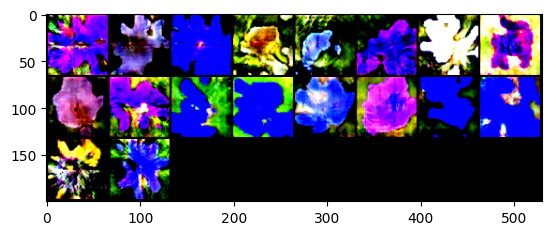

100%|██████████| 103/103 [00:09<00:00, 11.35it/s]


epoch: 24, lossD:0.12256232200606355, lossG:9.862776210007159,lossG_fake:5.287083429040261, lossG_real:4.5756927983274736 ,equality:0.7113906307127875


evaluate:110.8945541381836,kid_mean:0.07997364550828934, kid_std:0.04070565104484558,kid_:(tensor(0.0800), tensor(0.0407))


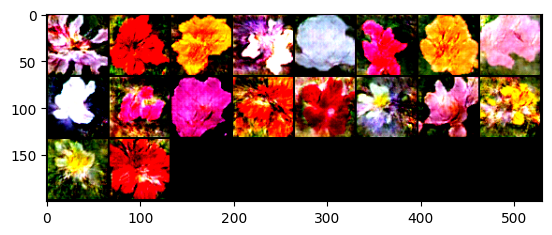

100%|██████████| 103/103 [00:09<00:00, 11.15it/s]


epoch: 25, lossD:0.17787911122646724, lossG:9.643972433886482,lossG_fake:5.06965968331087, lossG_real:4.574312711224972 ,equality:0.4953469720858976


evaluate:110.56769561767578,kid_mean:0.08117996156215668, kid_std:0.04269489273428917,kid_:(tensor(0.0812), tensor(0.0427))


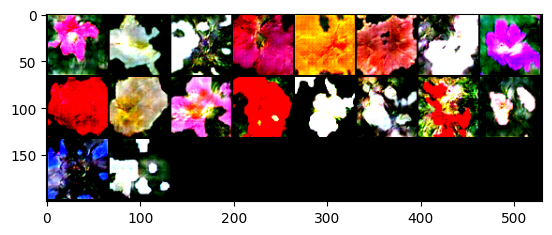

100%|██████████| 103/103 [00:09<00:00, 11.17it/s]


epoch: 26, lossD:0.10776974562808726, lossG:9.505296679376398,lossG_fake:4.917813085815282, lossG_real:4.58748354263676 ,equality:0.3303295431785216


evaluate:110.97686004638672,kid_mean:0.0718124583363533, kid_std:0.03852378949522972,kid_:(tensor(0.0718), tensor(0.0385))


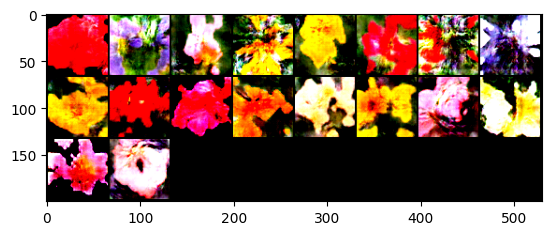

100%|██████████| 103/103 [00:08<00:00, 11.69it/s]


epoch: 27, lossD:0.24866711621362608, lossG:9.655493893669647,lossG_fake:5.1675190821434684, lossG_real:4.487974821363838 ,equality:0.6795442607796307


evaluate:110.83425903320312,kid_mean:0.07874756306409836, kid_std:0.039414841681718826,kid_:(tensor(0.0787), tensor(0.0394))


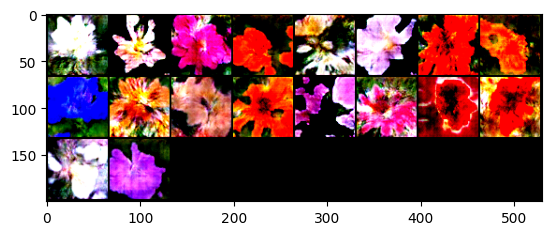

100%|██████████| 103/103 [00:08<00:00, 11.79it/s]


epoch: 28, lossD:0.1281044075753793, lossG:9.680196688013169,lossG_fake:5.178764438166202, lossG_real:4.501432255633826 ,equality:0.6773321825323757


evaluate:111.19519805908203,kid_mean:0.07535994797945023, kid_std:0.04009799286723137,kid_:(tensor(0.0754), tensor(0.0401))


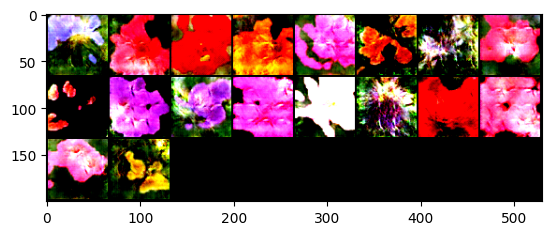

100%|██████████| 103/103 [00:09<00:00, 11.04it/s]


epoch: 29, lossD:0.12068679133086528, lossG:9.237600812634218,lossG_fake:4.825045923584873, lossG_real:4.412554854328192 ,equality:0.41249106925668055


evaluate:112.06961822509766,kid_mean:0.07529709488153458, kid_std:0.03811703249812126,kid_:(tensor(0.0753), tensor(0.0381))


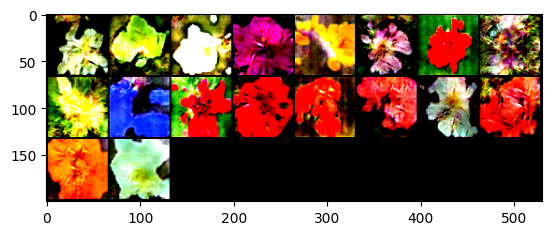

100%|██████████| 103/103 [00:09<00:00, 11.40it/s]


epoch: 30, lossD:0.08864939766167437, lossG:9.14436793558806,lossG_fake:4.753509178902339, lossG_real:4.390858807610076 ,equality:0.3626503712922631


evaluate:111.39962005615234,kid_mean:0.076537124812603, kid_std:0.03947073593735695,kid_:(tensor(0.0765), tensor(0.0395))


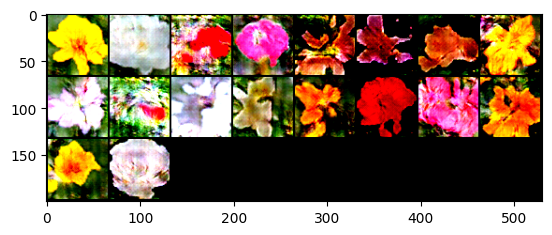

100%|██████████| 103/103 [00:09<00:00, 11.19it/s]


epoch: 31, lossD:0.2859896344394938, lossG:9.823237956148906,lossG_fake:5.226227753370711, lossG_real:4.597010267591013 ,equality:0.6292174857796979


evaluate:112.41463470458984,kid_mean:0.07820151001214981, kid_std:0.041159626096487045,kid_:(tensor(0.0782), tensor(0.0412))


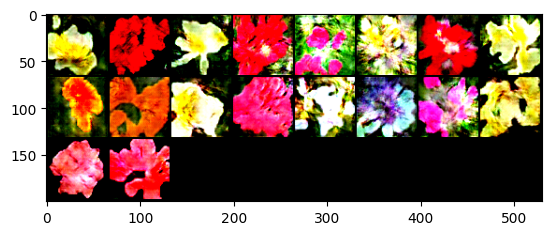

100%|██████████| 103/103 [00:09<00:00, 11.07it/s]


epoch: 32, lossD:0.1985442582337023, lossG:9.230599695039027,lossG_fake:4.901818869183365, lossG_real:4.328780844662953 ,equality:0.5730380245204119


evaluate:112.79090881347656,kid_mean:0.08097413182258606, kid_std:0.039145298302173615,kid_:(tensor(0.0810), tensor(0.0391))


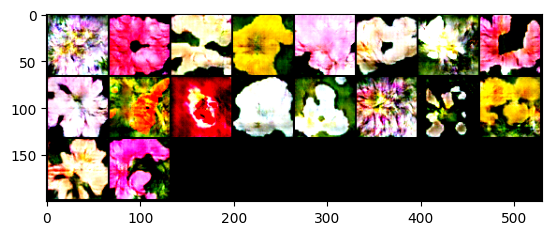

100%|██████████| 103/103 [00:08<00:00, 11.71it/s]


epoch: 33, lossD:0.13087515438933975, lossG:9.394707212170351,lossG_fake:4.94011251440326, lossG_real:4.454594671147541 ,equality:0.48551784325571834


evaluate:112.84408569335938,kid_mean:0.07637432217597961, kid_std:0.04301093891263008,kid_:(tensor(0.0764), tensor(0.0430))


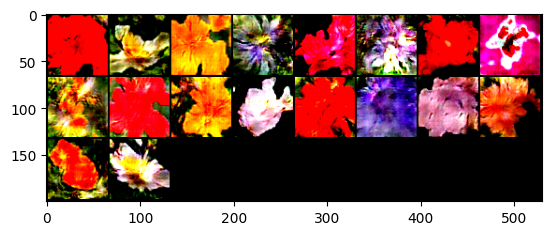

100%|██████████| 103/103 [00:08<00:00, 11.49it/s]


epoch: 34, lossD:0.15921084732902283, lossG:9.516381657239302,lossG_fake:5.029005430277111, lossG_real:4.487376184139437 ,equality:0.5416292461376742


evaluate:112.78874969482422,kid_mean:0.07870429009199142, kid_std:0.03894806653261185,kid_:(tensor(0.0787), tensor(0.0389))


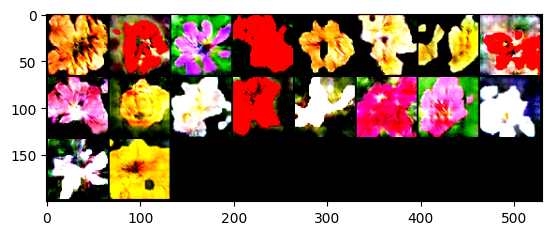

100%|██████████| 103/103 [00:09<00:00, 10.96it/s]


epoch: 35, lossD:0.1317063979985355, lossG:9.344575733814425,lossG_fake:4.930368851689459, lossG_real:4.414206893698683 ,equality:0.5161619579907759


evaluate:112.7865982055664,kid_mean:0.0760902464389801, kid_std:0.0418957844376564,kid_:(tensor(0.0761), tensor(0.0419))


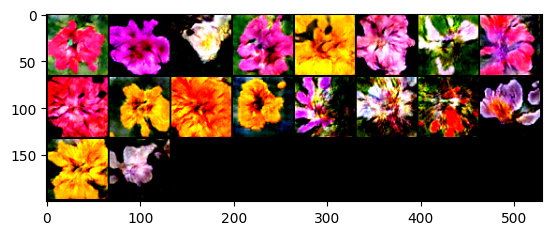

100%|██████████| 103/103 [00:09<00:00, 10.98it/s]


epoch: 36, lossD:0.10372200409330211, lossG:9.299281189742597,lossG_fake:4.795054692666508, lossG_real:4.50422644383699 ,equality:0.2908282488295173


evaluate:112.81315612792969,kid_mean:0.07938037067651749, kid_std:0.04003050923347473,kid_:(tensor(0.0794), tensor(0.0400))


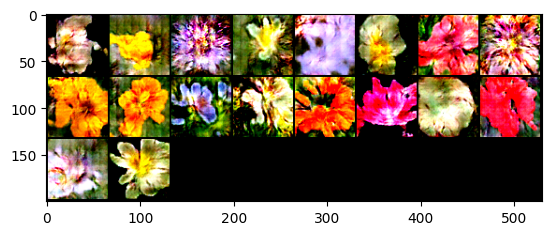

100%|██████████| 103/103 [00:09<00:00, 11.12it/s]


epoch: 37, lossD:0.1455326950521145, lossG:9.499252189710303,lossG_fake:4.957949550406447, lossG_real:4.54130266245129 ,equality:0.4166468879551566


evaluate:112.17174530029297,kid_mean:0.0783342644572258, kid_std:0.04230370372533798,kid_:(tensor(0.0783), tensor(0.0423))


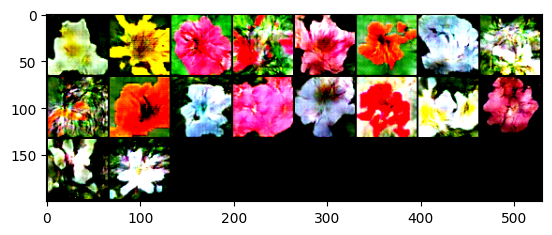

100%|██████████| 103/103 [00:09<00:00, 11.23it/s]


epoch: 38, lossD:0.152304868313294, lossG:9.421794294153603,lossG_fake:4.948708796385422, lossG_real:4.473085475199431 ,equality:0.47562332118599127


evaluate:112.2699203491211,kid_mean:0.08138658851385117, kid_std:0.04619724303483963,kid_:(tensor(0.0814), tensor(0.0462))


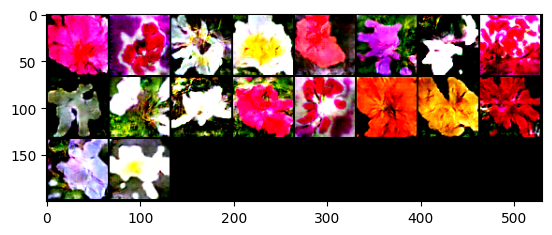

100%|██████████| 103/103 [00:08<00:00, 11.47it/s]


epoch: 39, lossD:0.14128298960734628, lossG:9.44572044576256,lossG_fake:4.939097571720198, lossG_real:4.5066228769357926 ,equality:0.43247469478440514


evaluate:112.35417938232422,kid_mean:0.07848228514194489, kid_std:0.038379378616809845,kid_:(tensor(0.0785), tensor(0.0384))


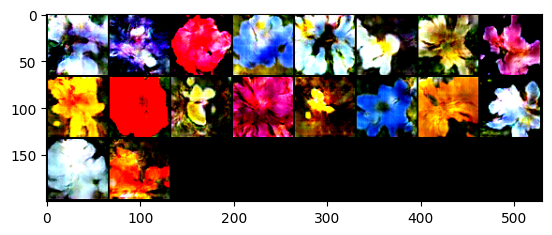

100%|██████████| 103/103 [00:09<00:00, 11.27it/s]


epoch: 40, lossD:0.18399601943284563, lossG:9.538960794800694,lossG_fake:4.972234845161438, lossG_real:4.566725911445988 ,equality:0.40550893371545005


evaluate:112.37339782714844,kid_mean:0.07209746539592743, kid_std:0.038014933466911316,kid_:(tensor(0.0721), tensor(0.0380))


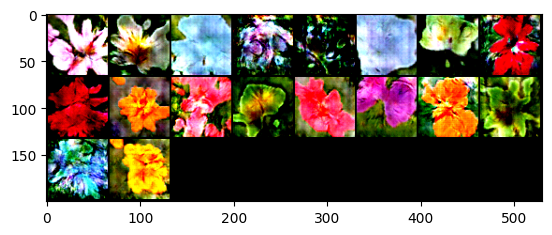

100%|██████████| 103/103 [00:09<00:00, 11.07it/s]


epoch: 41, lossD:0.09740893560850504, lossG:9.399586575702557,lossG_fake:4.863347208615646, lossG_real:4.536239384447486 ,equality:0.3271078241681593


evaluate:113.2143325805664,kid_mean:0.07333964109420776, kid_std:0.04089166969060898,kid_:(tensor(0.0733), tensor(0.0409))


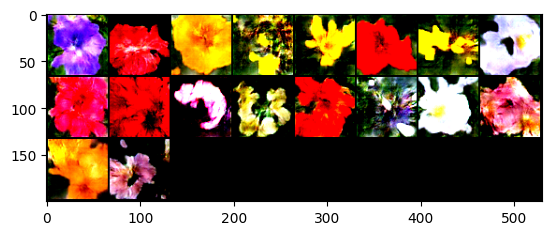

100%|██████████| 103/103 [00:09<00:00, 10.93it/s]


epoch: 42, lossD:0.11620314891260226, lossG:9.292688434563795,lossG_fake:4.825769216111563, lossG_real:4.466919211508001 ,equality:0.3588500046035614


evaluate:112.96084594726562,kid_mean:0.07815298438072205, kid_std:0.04308734089136124,kid_:(tensor(0.0782), tensor(0.0431))


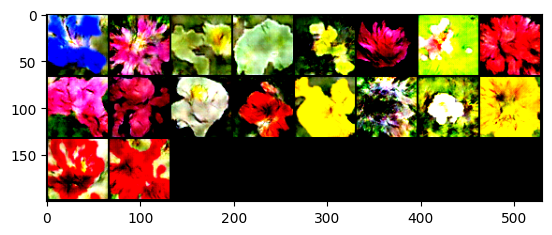

100%|██████████| 103/103 [00:09<00:00, 10.94it/s]


epoch: 43, lossD:0.37340283529489365, lossG:9.346152375045332,lossG_fake:5.076473501122114, lossG_real:4.26967886643647 ,equality:0.8067946346856436


evaluate:112.58435821533203,kid_mean:0.08262348920106888, kid_std:0.046807531267404556,kid_:(tensor(0.0826), tensor(0.0468))


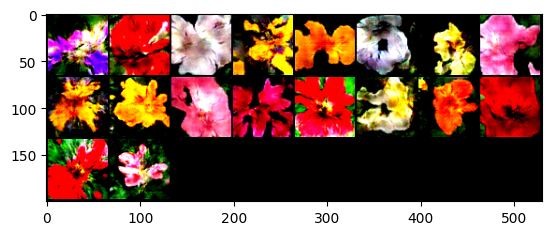

100%|██████████| 103/103 [00:08<00:00, 11.54it/s]


epoch: 44, lossD:0.13237188092785554, lossG:8.91141129928885,lossG_fake:4.59311480718909, lossG_real:4.318296459114667 ,equality:0.2748183480744224


evaluate:113.23838806152344,kid_mean:0.08383605629205704, kid_std:0.0446951724588871,kid_:(tensor(0.0838), tensor(0.0447))


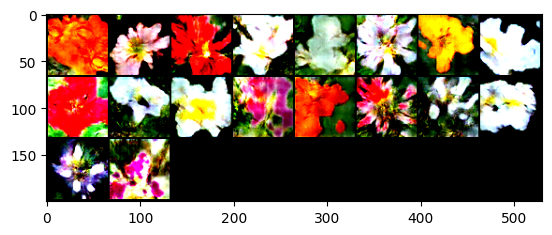

100%|██████████| 103/103 [00:09<00:00, 11.21it/s]


epoch: 45, lossD:0.09515091206525787, lossG:9.008187701401202,lossG_fake:4.728539221495101, lossG_real:4.279648454443922 ,equality:0.4488907670511786


evaluate:113.3115463256836,kid_mean:0.07451698929071426, kid_std:0.038498710840940475,kid_:(tensor(0.0745), tensor(0.0385))


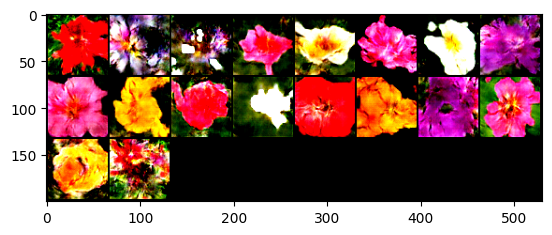

100%|██████████| 103/103 [00:09<00:00, 10.90it/s]


epoch: 46, lossD:0.14097241999454868, lossG:9.301884475263577,lossG_fake:4.808934936245668, lossG_real:4.492949537860537 ,equality:0.3159853983851315


evaluate:113.2532958984375,kid_mean:0.07680253684520721, kid_std:0.0359756238758564,kid_:(tensor(0.0768), tensor(0.0360))


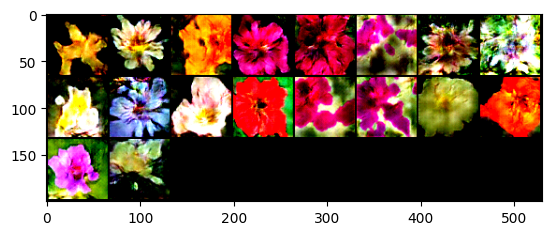

100%|██████████| 103/103 [00:09<00:00, 11.11it/s]


epoch: 47, lossD:0.1681162931061196, lossG:9.300426483154297,lossG_fake:4.83953872699182, lossG_real:4.460887789726257 ,equality:0.3786509372655624


evaluate:112.95780944824219,kid_mean:0.07927744835615158, kid_std:0.0480901263654232,kid_:(tensor(0.0793), tensor(0.0481))


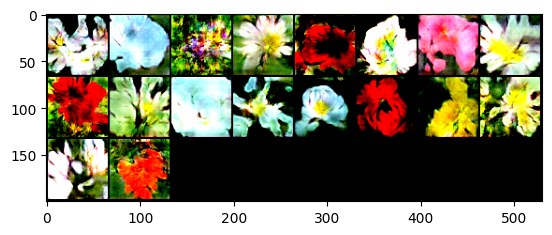

100%|██████████| 103/103 [00:09<00:00, 10.91it/s]


epoch: 48, lossD:0.16952951945075131, lossG:9.262489587357901,lossG_fake:4.781851668959683, lossG_real:4.480637957170171 ,equality:0.3012137117895115


evaluate:112.74456024169922,kid_mean:0.07868383824825287, kid_std:0.04388382285833359,kid_:(tensor(0.0787), tensor(0.0439))


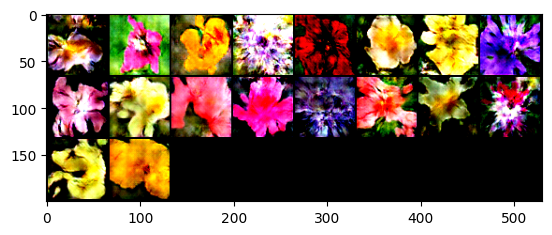

100%|██████████| 103/103 [00:09<00:00, 11.36it/s]


epoch: 49, lossD:0.2075946043127949, lossG:9.304015779958188,lossG_fake:4.805553819369344, lossG_real:4.498461967533075 ,equality:0.30709185183626886


evaluate:112.88652801513672,kid_mean:0.07543247938156128, kid_std:0.040219496935606,kid_:(tensor(0.0754), tensor(0.0402))


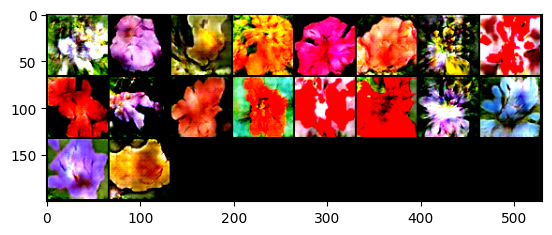

In [56]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

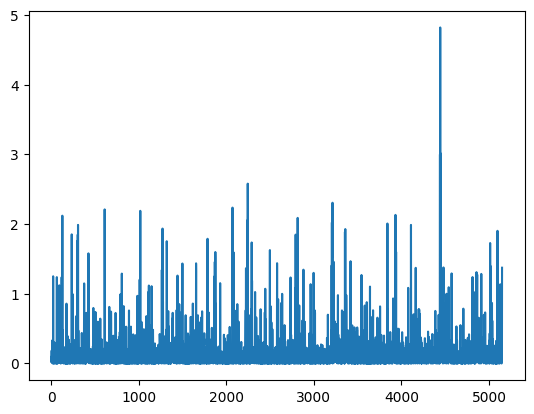

In [57]:
plt.plot(raw_lossesD)

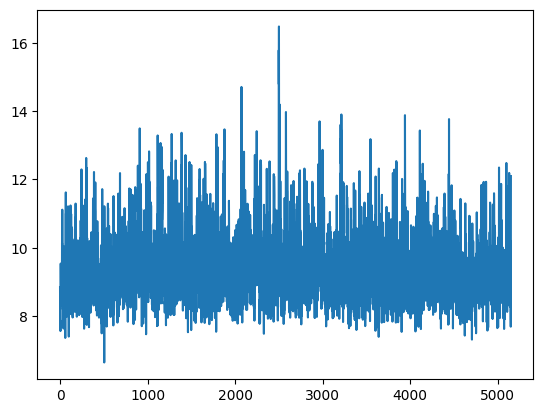

In [58]:
plt.plot(raw_lossesG)

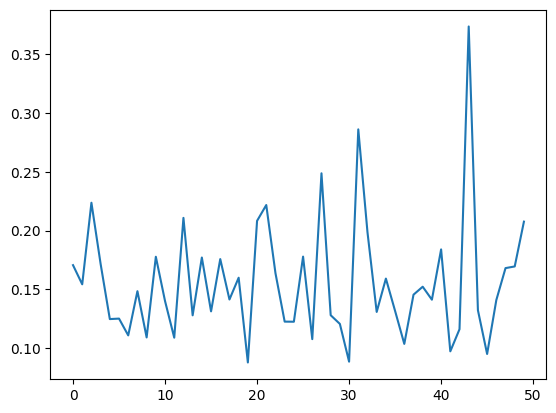

In [59]:
plt.plot(lossesD)

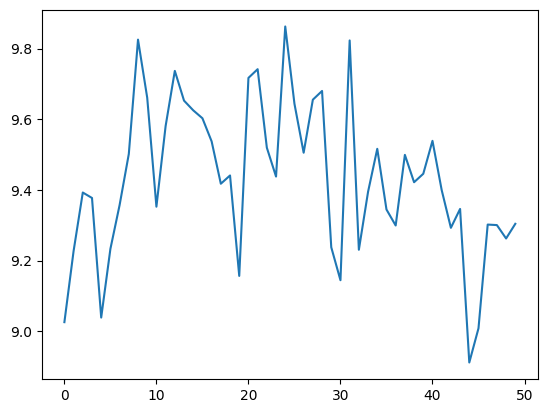

In [60]:
plt.plot(lossesG)

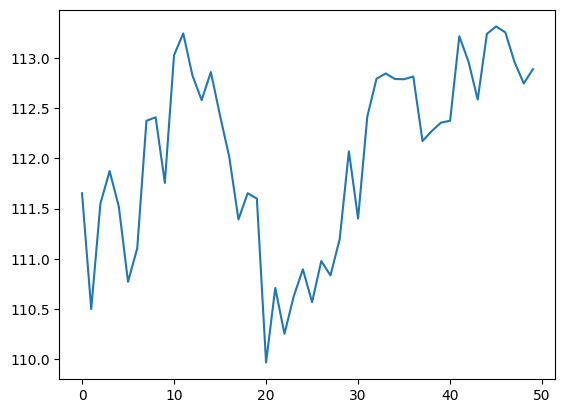

In [61]:
plt.plot(fid_)

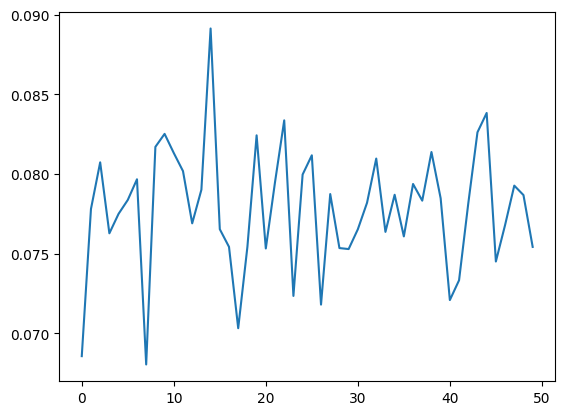

In [62]:
plt.plot(kid_mean_)

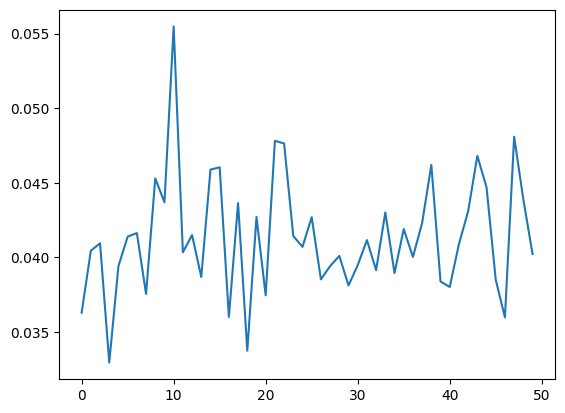

In [63]:
plt.plot(kid_std_)

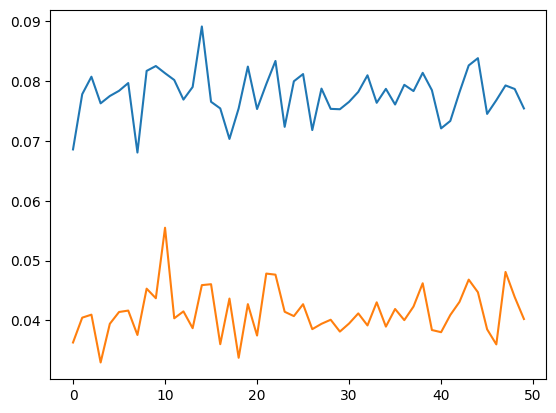

In [64]:
plt.plot(kid_score)

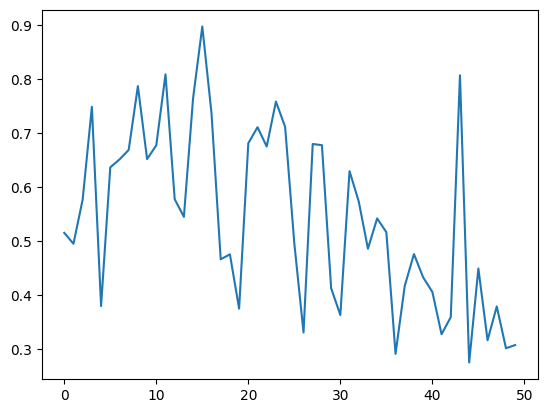

In [65]:
plt.plot(d_equality)

In [66]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0806), tensor(0.0402))